# Workflow to generate refractory alloy compositions and predict their strength

Steps in this notebook:

Training the models:

1) Train autoencoder to encode compositions and solidus temperatures into a 2D latent space
    Training data is Thermo-Calc equilibrium calculations with compositions randomly sampled from this element palette [Cr, Hf, Nb, Mo, Ta, Ti, Re, V, W, Zr]
    Thermo-Calc generated solidus temperature (Tsol), liquidus temperature (Tliq), and the fraction of ordered (N(OrdPh) and disordered (NDisordPh) phases at Tsol
    
2) Cluster the latent space by Tsol into four solidus temperature classes: 1000-1700, 1700-2400, 2400-3100, 3100-3800 K

3) Train a random forest model to predict alloy solidus temperature as a function of composition

4) Train a random forest regression model to predict alloy yield strength and ultimate tensile strength as a function of composition and temperature.
    Training data is from the literature.

Note:  There are saved versions of the autoencoder model in the '/alloy-main/model/' folder.  These models do not need to be retrained, see comments in cells below.

Using the models:

1) Sample points from clusters in the autoencoder latent space, this example draws from the 3100-3800K Tsolidus cluster

2) Decode with autoencoder to compositions with a specified range of Tsol

3) Predict solidus with random forest model

4) Predict yield strength and ultimate tensile strength with random forest model# Machine Learning for Refractory Alloy

Set `load_pretrain = False` if you want to train the models 

In [24]:
load_pretrain_autoencoder = True # Default: True
load_pretrain_RF_solidus = False # Default: False

## Import Function

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,accuracy_score,r2_score
# import seaborn as sns
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
from tqdm import tqdm
import pickle


## Autoencoder

In [3]:
# Load thermal_calc_data
thermal_calc_data = pd.read_csv('./data/thermal_calc_data.csv')

# elements input for autoencoder
thermal_calc_elements = thermal_calc_data.iloc[:,:10] 
thermal_calc_data

,Cr,Hf,Nb,Mo,Ta,Ti,Re,V,W,Zr,Tsol,Tliq,N(DisordPh),N(OrdPh),label
0,0.000118,0.998941,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118,2502.451483,2504.865528,1.000000,5.551115e-16,2
1,0.000007,0.000007,0.000007,0.117629,0.450665,0.000007,0.000007,0.000007,0.000007,0.431654,2097.106888,2459.654838,1.000000,4.440892e-16,1
2,0.000002,0.000002,0.167324,0.171807,0.176367,0.068896,0.170568,0.000002,0.164857,0.080175,2583.871560,3020.973714,0.909496,9.050374e-02,2
3,0.000017,0.000017,0.304175,0.298785,0.000017,0.000017,0.000017,0.000017,0.396919,0.000017,3083.701296,3161.717907,1.000000,0.000000e+00,2
4,0.000002,0.056453,0.090165,0.193152,0.149393,0.173742,0.080880,0.132468,0.073198,0.050547,2234.595472,2718.885815,1.000000,0.000000e+00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88067,0.381589,0.000008,0.000008,0.000008,0.577427,0.040928,0.000008,0.000008,0.000008,0.000008,2138.151692,2442.093468,0.648354,3.516462e-01,1
88068,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.355627,0.000007,0.644317,1542.517997,1635.777867,0.599724,4.002763e-01,0
88069,0.207365,0.000005,0.117824,0.000005,0.093911,0.143058,0.000005,0.108731,0.000005,0.329090,1615.368093,1791.171353,0.729354,2.706463e-01,0
88070,0.000020,0.000020,0.000020,0.999823,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,2895.728623,2895.940212,1.000000,4.440892e-16,2


### Plot the distribution of the Thermal-Calc data

['V', 'Nb', 'Ti', 'Mo', 'Ta', 'Hf', 'Cr', 'Zr', 'W', 'Re']


(-0.1, 1.1)

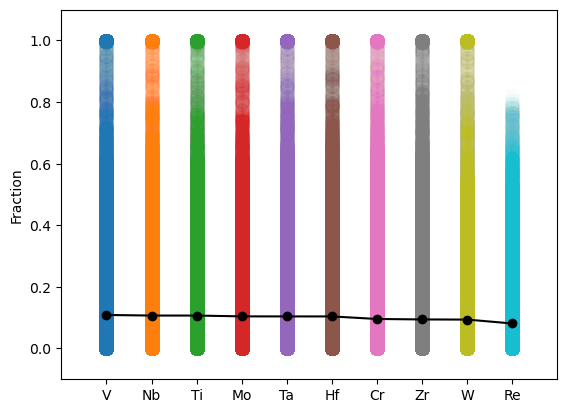

In [4]:
# Rank by average fraction
sort = thermal_calc_elements.mean().sort_values(ascending=False).reset_index()
sort_column = sort['index']
thermal_calc_elements = thermal_calc_elements[sort_column]
elements = thermal_calc_elements.columns.tolist()
print(elements)
x_index = np.zeros(len(thermal_calc_elements))
# plt.figure(figsize=(8,8))

for i in elements:
    condition = thermal_calc_elements[i] > 0.0
    plt.scatter(x_index[condition],thermal_calc_elements[i][condition],alpha=0.01,s = 100,marker='o')
    x_index+=1

plt.plot(range(len(elements)),sort[0],'ko-',label='Average Concentration')
# plt.legend()
plt.xticks(range(len(elements)),elements)
plt.ylabel('Fraction')
plt.xlim(-1,len(elements))
plt.ylim(-0.1,1.1)

Text(0, 0.5, 'Count')

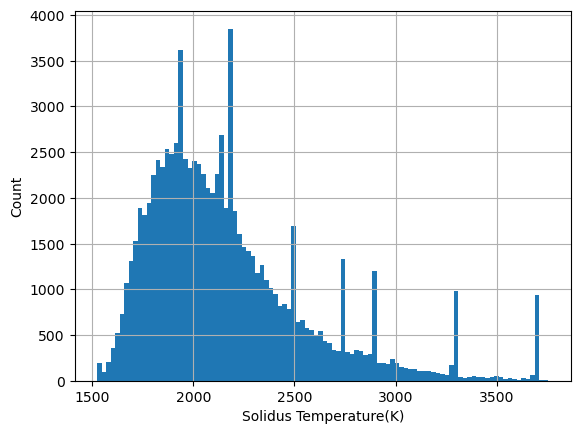

In [5]:
thermal_calc_data.Tsol.hist(bins=100)
plt.xlabel('Solidus Temperature(K)')
plt.ylabel('Count')

### Set up Dataloader for Autoencoder

In [6]:
# Create Dataset object 
class Alloy_Dataset(Dataset):
    def __init__(self, elements, labels):
        super().__init__()
        assert len(labels) == len(elements)
        self.elements = elements
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
      
    def __getitem__(self, index):
        input = self.elements[index]
        target = self.labels[index]
        return input , target

data = Alloy_Dataset(thermal_calc_elements.values,thermal_calc_data['label']) # classification
# data = Alloy_Dataset(thermal_calc_elements.values,thermal_calc_data['Tsol']) # regression

# train test split
train_ratio = 0.8
train_size = int(train_ratio * len(data))
test_size = len(data) - train_size
train_set, test_set = torch.utils.data.random_split(data, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Dataloader
train_loader = DataLoader(
    train_set, # The dataset
    batch_size=128,      # Batch size
    shuffle=True,      # Shuffles the dataset at every epoch
    pin_memory=True,   # Copy data to CUDA pinned memory                   # so that they can be transferred to the GPU very fast
    num_workers=0      # Number of worker processes for loading data.
                       # If zero, use the current process (blocks until data are loaded)
                       # Otherwise fork/spawn new processes (asynchronous load)
                       # Spawning new processes can be problematic on Windows, see:
                       # https://pytorch.org/docs/stable/notes/windows.html#usage-multiprocessing
                       )
test_loader = DataLoader(test_set,batch_size=128,shuffle=False,pin_memory=True,num_workers=0)

In [12]:
# Check cuda 
device = "cuda" if torch.cuda.is_available() else "cpu"
# 'cuda: 0' if multiple GPUs
print(device)

cpu


## Architecture of Autoencoder

In [8]:
# Autoencoder Model
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(10,24),
            nn.ReLU(True),
            nn.Linear(24,48),
            nn.ReLU(True),
            nn.Linear(48,64),
            nn.ReLU(True),
            nn.Linear(64,32),
            nn.ReLU(True),
            nn.Linear(32,16),
            nn.ReLU(True),
            nn.Linear(16,8),
            nn.ReLU(True),
            nn.Linear(8,4),
            nn.ReLU(True),
            nn.Linear(4,2)
            #nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2,4),
            nn.ReLU(True),
            nn.Linear(4,8),
            nn.ReLU(True),
            nn.Linear(8,16),
            nn.ReLU(True),
            nn.Linear(16,32),
            nn.ReLU(True),
            nn.Linear(32,64),
            nn.ReLU(True),
            nn.Linear(64,48),
            nn.ReLU(True),
            nn.Linear(48,24),
            nn.ReLU(True),
            nn.Linear(24,10),
            nn.ReLU(True),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2,4)
        )

    def forward(self, input):
        en_out  = self.encoder(input)
        pred   = self.classifier(en_out)
        de_out  = self.decoder(en_out)
        return en_out,de_out, pred



## Set up for training the model

In [13]:
# Put model into GPU if available
model = autoencoder().double().to(device)

# parameters set up
epochs = 300
loss_ratio = 2
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
criterion3 = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler =  lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)

### Training 

In [14]:
if load_pretrain_autoencoder:
    pass
else:
    # trainning
    training_loss = []
    testing_loss = []
    pbar = tqdm(range(epochs))
    for i in pbar:
        epoch_loss = 0.0
        for input, target in train_loader:
            model.train()
            input = input.to(device)
            target = target.to(device)
            optimizer.zero_grad() 

            encode_output,decode_output, prediction = model(input)
            loss = criterion1(decode_output,input) + 2 * criterion2(prediction,target) # classification
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix_str({'Epoch': i,'Training Loss': loss.item()})
        epoch_loss /= len(train_loader)
        training_loss.append(epoch_loss)
        scheduler.step(epoch_loss)
    plt.plot(range(len(training_loss)),training_loss)
    plt.title('Loss vs Epochs')
    plt.xlabel('epoch')
    plt.ylabel('Loss')

### Saving or Loading Model

In [15]:
if load_pretrain_autoencoder:
    saving_path = './model/my_model.pth'
    model = autoencoder().double().to(device)
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(saving_path),strict=True)
    else:
        model.load_state_dict(torch.load(saving_path,map_location=torch.device('cpu')),strict=True)
else:
    saving_path = './model/model.pth'
    torch.save(model.state_dict(),saving_path)


### Test the performance

In [16]:
pred_list = []
target_list = []
encode_list = []
with torch.no_grad():
    for input, target in test_loader:
        model.eval()
        input = input.to(device)
        target_list += target.detach().cpu().numpy().tolist()
        encode_output,decode_output, prediction = model(input)
        encode_list += encode_output.detach().cpu().numpy().tolist()
        pred_list += prediction.detach().cpu().numpy().tolist()
    pred_list = np.argmax(pred_list,axis=1)
    encode_array=np.array(encode_list)
print(f'Accuracy of the Model is {accuracy_score(pred_list,target_list).round(5)}')

Accuracy of the Model is 0.97746


## Random Forest Regressor for Solidus Temperature

In [25]:
rf_solt = RandomForestRegressor(n_estimators=200,random_state=42)
X = thermal_calc_elements
y = thermal_calc_data['Tsol']
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
if load_pretrain_RF_solidus:
    print(f'Loading Model')
    with open('./model/RF_solidus.pkl','rb') as f:
        rf_solt = pickle.load(f)
else:
    print('Saving Model')
    rf_solt.fit(X_train,y_train)
    with open('./model/RF_solidus.pkl','wb') as f:
        pickle.dump(rf_solt,f)
y_pred = rf_solt.predict(X_test)
print(f'R^2 score = {r2_score(y_pred,y_test)}')
print(f'MAE = {mean_absolute_error(y_pred,y_test)}')

Loading Model
R^2 score = 0.9876107224785097
MAE = 26.400262952323658


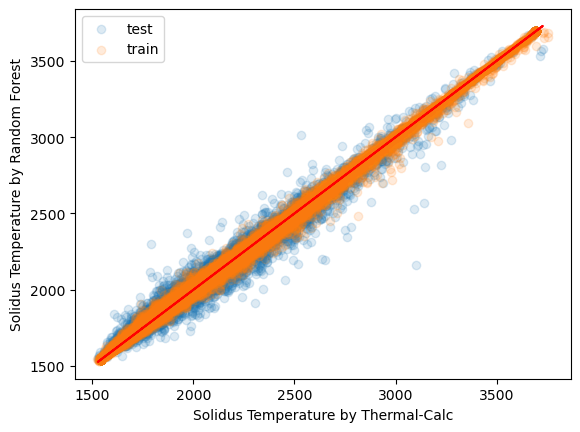

In [26]:
y_pred_train = rf_solt.predict(X_train)
plt.plot(y_test,y_test,'r')
plt.scatter(y_test,y_pred,alpha=0.15,label='test')
plt.scatter(y_train,y_pred_train,alpha=0.15,label='train')
plt.xlabel('Solidus Temperature by Thermal-Calc')
plt.ylabel('Solidus Temperature by Random Forest')
plt.legend()

### Latent Space

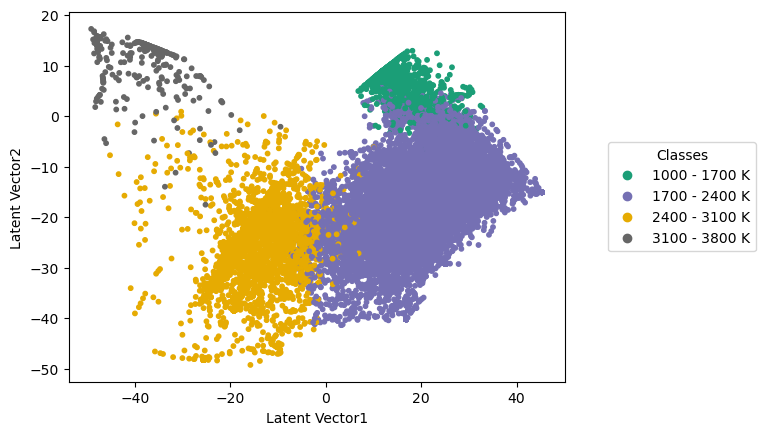

In [27]:
fig, ax = plt.subplots()
labels = ['1000 - 1700 K', '1700 - 2400 K', '2400 - 3100 K', '3100 - 3800 K']  # Custom labels for the points
scatter = ax.scatter(encode_array[:,0],encode_array[:,1], c= target_list,label = labels,s=10,cmap=plt.cm.get_cmap('Dark2',4))
# legend1 = ax.legend(*scatter.legend_elements(), loc = 'best',title = 'Classes')
plt.xlabel('Latent Vector1')
plt.ylabel('Latent Vector2')
# plt.legend(loc = 'lower left')
#plt.xlim(-3,10.5)
#plt.ylim(-1,1)
# plt.axes('off')
# ax.add_artist(legend1)
handles, _ = scatter.legend_elements()
legend1 = ax.legend(handles, labels, loc='center right', title='Classes',bbox_to_anchor=(1.4, 0.5))


## Random Forest Regressor for Strength 

In [28]:
# Load Data 
strength_name = 'YS'
strength = pd.read_csv('./data/ys_clean.csv')
include_tsol = True
# Including Solidus temperature if available

augment = True # Augmentation
ratio = True # Ratio of Tsol and T test
if include_tsol == False:
    strength.drop(columns=['Solidus temperature'],inplace=True)
elif ratio == True:
    strength['ratio'] = strength['Test temp']/strength['Solidus temperature']
strength

,Test temp,YS,Solidus temperature,W,Nb,Hf,Mo,Re,Zr,Ta,Ti,C,Y,Al,Si,V,Cr,ratio
0,810.927778,875.632593,3693.60864,9.999529e-01,0.000002,0.000001,0.000002,9.872537e-07,0.000002,0.000001,0.000004,0.000015,0.000002,0.000007,0.000007,0.000004,0.0,0.219549
1,810.927778,854.948358,3693.60864,9.999529e-01,0.000002,0.000001,0.000002,9.872537e-07,0.000002,0.000001,0.000004,0.000015,0.000002,0.000007,0.000007,0.000004,0.0,0.219549
2,1088.705556,820.474634,3693.60864,9.999529e-01,0.000002,0.000001,0.000002,9.872537e-07,0.000002,0.000001,0.000004,0.000015,0.000002,0.000007,0.000007,0.000004,0.0,0.294754
3,1088.705556,792.895655,3693.60864,9.999529e-01,0.000002,0.000001,0.000002,9.872537e-07,0.000002,0.000001,0.000004,0.000015,0.000002,0.000007,0.000007,0.000004,0.0,0.294754
4,1366.483333,627.421779,3693.60864,9.999529e-01,0.000002,0.000001,0.000002,9.872537e-07,0.000002,0.000001,0.000004,0.000015,0.000002,0.000007,0.000007,0.000004,0.0,0.369959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,298.150000,1369.000000,2399.80129,6.485527e-07,0.199996,0.199996,0.199996,6.403085e-07,0.000001,0.199991,0.199996,0.000010,0.000001,0.000004,0.000004,0.000002,0.0,0.124239
809,1073.150000,822.000000,2399.80129,6.485527e-07,0.199996,0.199996,0.199996,6.403085e-07,0.000001,0.199991,0.199996,0.000010,0.000001,0.000004,0.000004,0.000002,0.0,0.447183
810,1273.150000,778.000000,2399.80129,6.485527e-07,0.199996,0.199996,0.199996,6.403085e-07,0.000001,0.199991,0.199996,0.000010,0.000001,0.000004,0.000004,0.000002,0.0,0.530523
811,1473.150000,699.000000,2399.80129,6.485527e-07,0.199996,0.199996,0.199996,6.403085e-07,0.000001,0.199991,0.199996,0.000010,0.000001,0.000004,0.000004,0.000002,0.0,0.613863


### Visulization of data distribution

['W', 'Ta', 'Nb', 'Ti', 'Zr', 'Mo', 'Hf', 'Re', 'V', 'Al', 'C', 'Si', 'Y', 'Cr']


(-0.1, 1.1)

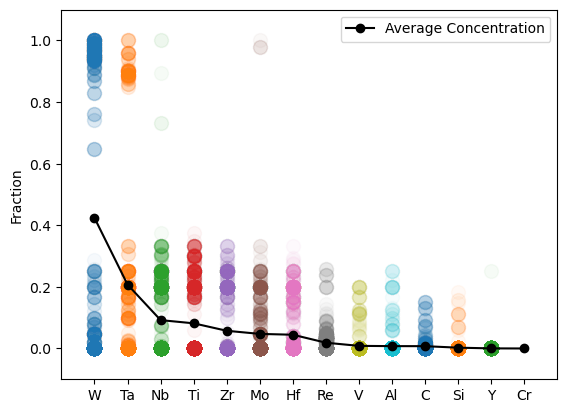

In [29]:
if include_tsol:
    if ratio:
        strength_element = strength.iloc[:,3:-1]
    else:
        strength_element = strength.iloc[:,3:]
else:
    strength_element = strength.iloc[:,2:]
# Rank by average fraction
sort = strength_element.mean().sort_values(ascending=False).reset_index()
sort_column = sort['index']
strength_element = strength_element[sort_column]
strength_element
elements = strength_element.columns.tolist()
print(elements)
x_index = np.zeros(len(strength))
# plt.figure(figsize=(8,8))

for i in elements:
    condition = strength_element[i] > 0.0
    plt.scatter(x_index[condition],strength_element[i][condition],alpha=0.04,s = 100,marker='o')
    x_index+=1

plt.plot(range(len(elements)),sort[0],'ko-',label='Average Concentration')
plt.legend()
plt.xticks(range(len(elements)),elements)
plt.ylabel('Fraction')
plt.xlim(-1,len(elements))
plt.ylim(-0.1,1.1)

Text(0, 0.5, 'Count')

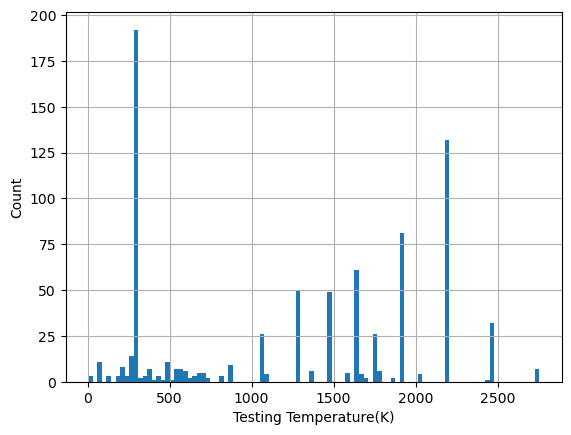

In [30]:
strength['Test temp'].hist(bins=100)
plt.xlabel('Testing Temperature(K)')
plt.ylabel('Count')

### Augmentation
Set `Strength = 0` at `Solidus Temperature` into train set. Prevent Strength at above alloy Solidus Temperature

In [34]:
# Augmentation required solidus temperature
if augment == True:
       augmented_data = strength.copy()
       augmented_data['Test temp'] = augmented_data['Solidus temperature']
       if ratio ==True:
              augmented_data['ratio'] = augmented_data['Test temp']/augmented_data['Solidus temperature']

       augmented_data.drop(columns=[strength_name],inplace=True)
# augmented_data

### Train and Test

R^2 value of the model is 0.929287471744481
Mean absolut Error(MAE) of the model is 104.17076858555485


Text(0, 0.5, 'Prediction Value of YS[MPa]')

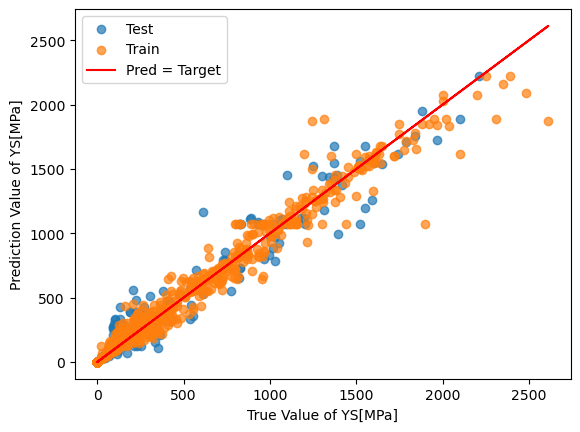

In [36]:
X = strength.drop(columns=[strength_name])
y = strength[strength_name]

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

if augment:
    X_train = pd.concat([X_train,augmented_data])
    y_train = y_train.tolist() + np.zeros([len(augmented_data)]).tolist()
    y_train = np.array(y_train)
rf = RandomForestRegressor(n_estimators=200,random_state=42)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
print(f'R^2 value of the model is {rf.score(X_test,y_test)}')
print(f'Mean absolut Error(MAE) of the model is {mean_absolute_error(y_pred,y_test)}')

fig, ax = plt.subplots()
plt.scatter(y_test,y_pred,label='Test',alpha=0.7)
plt.scatter(y_train,y_pred_train,label='Train',alpha=0.7)
plt.plot(y_train,y_train,'r',label='Pred = Target')
plt.legend()
plt.xlabel(f'True Value of {strength_name}[MPa]')
plt.ylabel(f'Prediction Value of {strength_name}[MPa]')

## Generate New Composition

In [37]:
high_tsol = thermal_calc_data[thermal_calc_data['label']==3]
high_tsol

,Cr,Hf,Nb,Mo,Ta,Ti,Re,V,W,Zr,Tsol,Tliq,N(DisordPh),N(OrdPh),label
7,0.000017,0.000017,0.000017,0.000017,0.999848,0.000017,0.000017,0.000017,0.000017,0.000017,3289.419481,3289.907351,1.0,-2.220446e-16,3
8,0.000009,0.000009,0.222806,0.000009,0.000009,0.000009,0.000009,0.000009,0.777121,0.000009,3371.503017,3460.717574,1.0,-2.220446e-16,3
33,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.999899,0.000011,3694.461706,3694.792263,1.0,-2.220446e-16,3
51,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.999903,0.000011,3694.479268,3694.797049,1.0,-2.220446e-16,3
133,0.000084,0.000084,0.000084,0.000084,0.999248,0.000084,0.000084,0.000084,0.000084,0.000084,3287.002041,3289.407003,1.0,-4.440892e-16,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87940,0.000022,0.000022,0.000022,0.000022,0.730959,0.000022,0.000022,0.000022,0.268863,0.000022,3397.394203,3410.270622,1.0,1.110223e-16,3
87958,0.000004,0.000004,0.000004,0.256122,0.342769,0.017080,0.309863,0.000004,0.074146,0.000004,3225.693294,3311.632099,1.0,0.000000e+00,3
87988,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.999858,0.000016,3694.281286,3694.743087,1.0,1.110223e-16,3
88013,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.999865,0.000015,3694.311039,3694.751197,1.0,2.220446e-16,3


['W', 'Ta', 'Mo', 'Re', 'Nb', 'V', 'Ti', 'Zr', 'Hf', 'Cr']


(-0.1, 1.1)

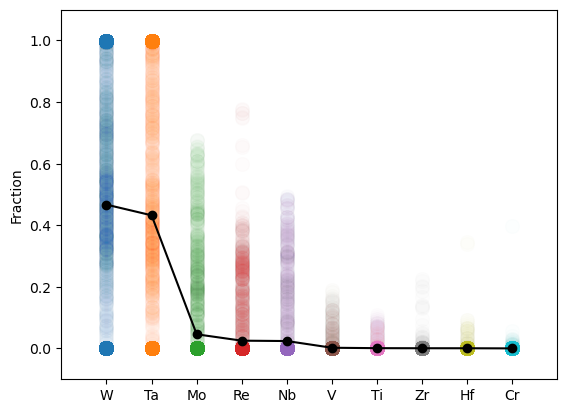

In [38]:
thermal_calc_elements = high_tsol.iloc[:,:-5]
sort = thermal_calc_elements.mean().sort_values(ascending=False).reset_index()
sort_column = sort['index']
thermal_calc_elements = thermal_calc_elements[sort_column]
elements = thermal_calc_elements.columns.tolist()
print(elements)
x_index = np.zeros(len(thermal_calc_elements))
# plt.figure(figsize=(8,8))

for i in elements:
    condition = thermal_calc_elements[i] > 0.0
    plt.scatter(x_index[condition],thermal_calc_elements[i][condition],alpha=0.01,s = 100,marker='o')
    x_index+=1

plt.plot(range(len(elements)),sort[0],'ko-',label='Average Concentration')
# plt.legend()
plt.xticks(range(len(elements)),elements)
plt.ylabel('Fraction')
plt.xlim(-1,len(elements))
plt.ylim(-0.1,1.1)

### Sampling and Decoding

In [42]:
high_tsol_elements = high_tsol.iloc[:,:-5]
high_tsol_tensor = torch.Tensor(high_tsol_elements.to_numpy()).double().to(device)
latent_high_tsol = model.encoder(high_tsol_tensor).detach().cpu().numpy()
new_composition_latent = []
# Generate sample
sample_number = 1000
for i in range(sample_number):
    a,b = np.random.choice(len(latent_high_tsol),2)
    new_x = (latent_high_tsol[a][0]  + latent_high_tsol[b][0])/2 
    new_y = (latent_high_tsol[a][1]  + latent_high_tsol[b][1])/2
    new_composition_latent.append([new_x,new_y])

# Decode to composition
new_composition = model.decoder(torch.Tensor(new_composition_latent).double().to(device))
new_composition = new_composition.detach().cpu().numpy()

# Scaled fraction into sum = 1.0
new_composition_df = pd.DataFrame(new_composition)
new_composition_df.columns = high_tsol_elements.columns
new_composition_df['sum'] = new_composition_df.sum(axis=1)
for x in high_tsol_elements:
    new_composition_df[x] /= new_composition_df['sum']
new_composition_df.drop(columns=['sum'],inplace=True)
new_composition_df

,Cr,Hf,Nb,Mo,Ta,Ti,Re,V,W,Zr
0,0.0,0.080782,0.0,0.063577,0.339448,0.0,0.0,0.000000,0.516193,0.000000
1,0.0,0.080871,0.0,0.066308,0.334453,0.0,0.0,0.000000,0.518368,0.000000
2,0.0,0.078760,0.0,0.075565,0.317917,0.0,0.0,0.000000,0.527758,0.000000
3,0.0,0.080686,0.0,0.073777,0.324616,0.0,0.0,0.000000,0.520920,0.000000
4,0.0,0.228690,0.0,0.000000,0.154122,0.0,0.0,0.000000,0.288610,0.328578
...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.077113,0.0,0.061874,0.393838,0.0,0.0,0.000000,0.467175,0.000000
996,0.0,0.080871,0.0,0.066360,0.334381,0.0,0.0,0.000000,0.518388,0.000000
997,0.0,0.037109,0.0,0.036893,0.195760,0.0,0.0,0.000000,0.730238,0.000000
998,0.0,0.080871,0.0,0.066410,0.334311,0.0,0.0,0.000000,0.518408,0.000000


### Use RF_solidus to predict the Solidus Temperature for new composition

In [43]:
new_composition_df['Solidus temperature'] = rf_solt.predict(new_composition_df)
# new_composition_df

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Text(0, 0.5, 'YS (MPa)')

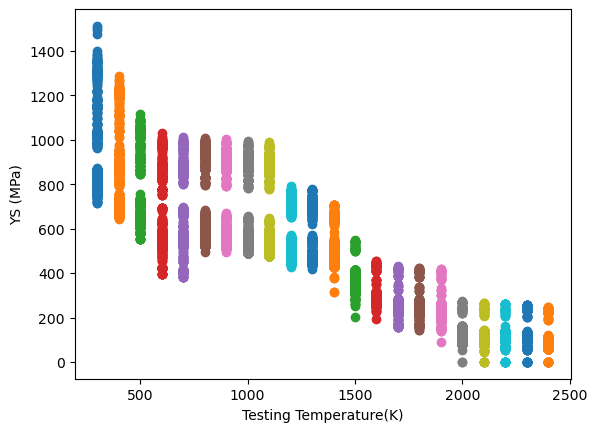

In [44]:
new_input = pd.concat([X_train.iloc[:1,:],new_composition_df])
new_input = new_input.iloc[1:,:]
new_input.fillna(0,inplace=True)
output_file = new_input.drop(columns=['Test temp'])
# Prediction for different Testing Temperature
T_test_list = np.arange(300,2500,100)
for t in T_test_list:
    new_input['Test temp'] = t
    if ratio:
        new_input['ratio'] = new_input['Test temp']/new_input['Solidus temperature']
    pred = rf.predict(new_input)
    output_file[f'{strength_name}_{t}K'] = pred
    plt.scatter(t*np.ones(len(pred)),pred)
plt.xlabel('Testing Temperature(K)')
plt.ylabel(f'{strength_name} (MPa)')

### Saving New Alloy Strength Prediction

In [45]:
if ratio:    
    output_file.drop(columns=['ratio'],inplace=True)
output_file.to_csv(f'./output/new_alloy_{strength_name}.csv',index=None)
output_file

,Solidus temperature,W,Nb,Hf,Mo,Re,Zr,Ta,Ti,C,...,YS_1500K,YS_1600K,YS_1700K,YS_1800K,YS_1900K,YS_2000K,YS_2100K,YS_2200K,YS_2300K,YS_2400K
0,3373.689564,0.516193,0.0,0.080782,0.063577,0.0,0.000000,0.339448,0.0,0.0,...,395.142367,304.674059,275.100920,268.104335,257.034761,153.315918,136.639955,136.651446,128.946166,111.476811
1,3374.942826,0.518368,0.0,0.080871,0.066308,0.0,0.000000,0.334453,0.0,0.0,...,395.142367,304.556848,274.983709,267.245939,257.034761,153.315918,136.639955,136.806578,128.946166,111.476811
2,3369.297417,0.527758,0.0,0.078760,0.075565,0.0,0.000000,0.317917,0.0,0.0,...,412.081790,308.789435,279.485192,271.955987,261.951077,157.328161,140.711378,137.627763,130.182414,113.028265
3,3373.010351,0.520920,0.0,0.080686,0.073777,0.0,0.000000,0.324616,0.0,0.0,...,399.364447,309.362848,279.086446,272.358756,261.289182,157.328161,140.711378,137.882869,130.177588,113.028265
4,2936.447842,0.288610,0.0,0.228690,0.000000,0.0,0.328578,0.154122,0.0,0.0,...,405.691451,308.215553,267.989064,257.760139,246.780332,150.172031,134.629911,133.296502,124.335284,108.536119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3332.628733,0.467175,0.0,0.077113,0.061874,0.0,0.000000,0.393838,0.0,0.0,...,389.756299,307.447470,275.372556,267.243394,259.789346,152.143679,137.150913,133.333363,125.847298,111.253996
996,3374.942826,0.518388,0.0,0.080871,0.066360,0.0,0.000000,0.334381,0.0,0.0,...,395.142367,304.556848,274.983709,267.245939,257.034761,153.315918,136.639955,136.806578,128.946166,111.476811
997,3554.660225,0.730238,0.0,0.037109,0.036893,0.0,0.000000,0.195760,0.0,0.0,...,396.282295,314.849812,265.684151,259.577713,252.542533,146.841406,131.636762,125.995370,126.489493,102.104804
998,3374.942826,0.518408,0.0,0.080871,0.066410,0.0,0.000000,0.334311,0.0,0.0,...,395.142367,304.556848,274.983709,267.245939,257.034761,153.315918,136.639955,136.806578,128.946166,111.476811
